In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

# Data prep for simulation

## BSM flow by 5 minutes

In [2]:
bsm_data_train = pd.read_csv('data/train/bsm_data_train.csv')
bsm_data_test = pd.read_csv('data/test/bsm_data_test_outliers.csv')

bsm_data_train['MessageReceivedDate'] = pd.to_datetime(bsm_data_train['MessageReceivedDate'])
bsm_data_test['MessageReceivedDate'] = pd.to_datetime(bsm_data_test['MessageReceivedDate'])

combined_bsm_data = pd.concat([bsm_data_train, bsm_data_test], ignore_index=True)
combined_bsm_data = combined_bsm_data.sort_values(by=['MessageReceivedDate'],ignore_index=True)

ground_truth = combined_bsm_data.groupby(pd.Grouper(key='MessageReceivedDate', freq='5T')).size().reset_index(name='count')
ground_truth.rename(columns={'MessageReceivedDate': 'timestamp'}, inplace=True)
ground_truth = ground_truth.sort_values(by=['timestamp'],ignore_index=True)
ground_truth.head()

C:\Users\lebed\AppData\Local\Temp\ipykernel_7476\1188712796.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ground_truth = combined_bsm_data.groupby(pd.Grouper(key='MessageReceivedDate', freq='5T')).size().reset_index(name='count')


,timestamp,count
0,2023-07-01 00:00:00,100
1,2023-07-01 00:05:00,89
2,2023-07-01 00:10:00,125
3,2023-07-01 00:15:00,123
4,2023-07-01 00:20:00,122


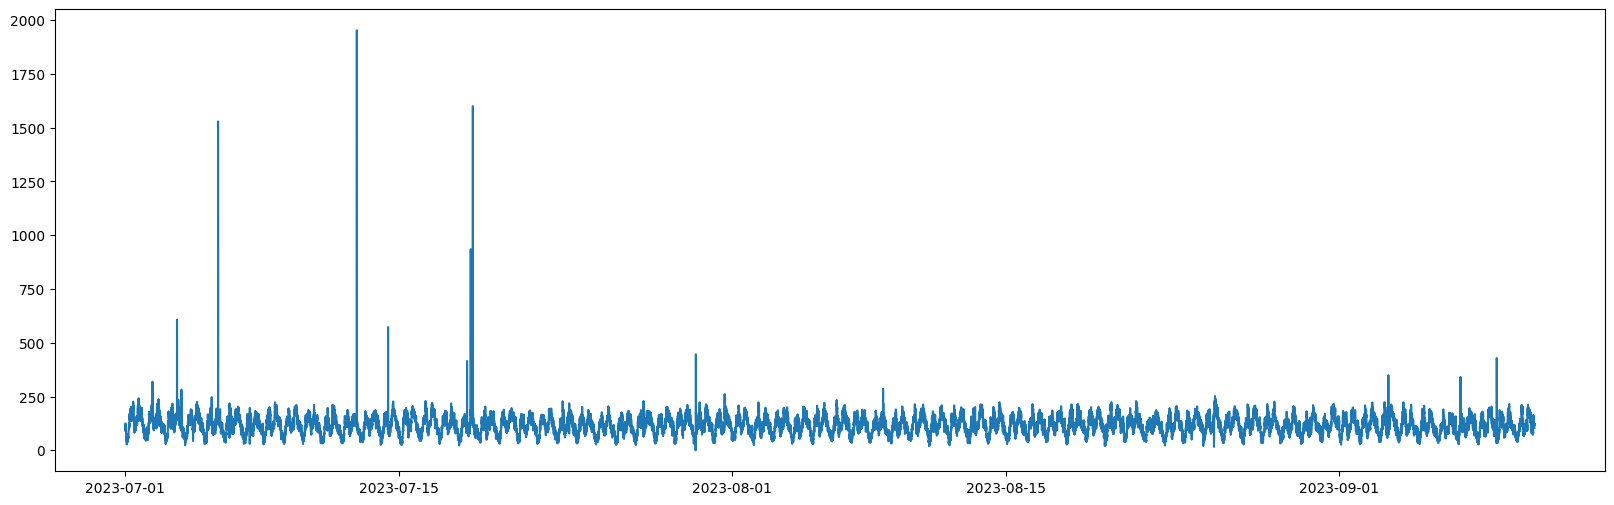

In [3]:
plt.figure(figsize=(20, 6))
plt.plot(ground_truth['timestamp'], ground_truth['count'])
plt.show()

## Anomalies by 5 minutes

In [5]:
y_train = pd.read_csv('data/tmp/train_y.csv',usecols=['timestamp', 'actualAnomaly'])
y_test = pd.read_csv('data/tmp/test_y.csv',usecols=['timestamp', 'actualAnomaly'])

y_train['timestamp'] = pd.to_datetime(y_train['timestamp'])
y_test['timestamp'] = pd.to_datetime(y_test['timestamp'])

combined_anomalies = pd.concat([y_train, y_test], ignore_index=True)
combined_anomalies = combined_anomalies.sort_values(by=['timestamp'],ignore_index=True)

combined_anomalies = combined_anomalies.groupby(pd.Grouper(key='timestamp', freq='5T'))["actualAnomaly"].sum().reset_index(name='actualAnomaly')
combined_anomalies['actualAnomaly'] = combined_anomalies['actualAnomaly'].apply(lambda x: 1 if x >= 1 else 0)
combined_anomalies["actualAnomaly"].value_counts()

C:\Users\lebed\AppData\Local\Temp\ipykernel_7476\3443619638.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  combined_anomalies = combined_anomalies.groupby(pd.Grouper(key='timestamp', freq='5T'))["actualAnomaly"].sum().reset_index(name='actualAnomaly')


actualAnomaly
0    20686
1       50
Name: count, dtype: int64

## Arrival distribution dictionray (profile_value_dict)

In [6]:
profile_value_dict = pd.read_csv('data/train/arrival_profile_value.csv')
profile_value_dict['value'] = profile_value_dict['value'].apply(lambda x: round(x, 6))
profile_value_dict

,checkin_terminal,airline_grouped_hash,arrival_profile,value,season
0,B,7bac920cc30511dfb81ca2242b293990,180.0,0.008569,S23
1,B,7bac920cc30511dfb81ca2242b293990,185.0,0.008135,S23
2,B,7bac920cc30511dfb81ca2242b293990,190.0,0.007548,S23
3,B,7bac920cc30511dfb81ca2242b293990,195.0,0.007107,S23
4,B,7bac920cc30511dfb81ca2242b293990,200.0,0.006526,S23
...,...,...,...,...,...
1315,C,4bba3ab232fc6c57e7dbb1f5932b61d0,140.0,0.038291,S23
1316,C,4bba3ab232fc6c57e7dbb1f5932b61d0,145.0,0.034149,S23
1317,C,4bba3ab232fc6c57e7dbb1f5932b61d0,150.0,0.035884,S23
1318,C,4bba3ab232fc6c57e7dbb1f5932b61d0,155.0,0.032785,S23


1.0 0.0


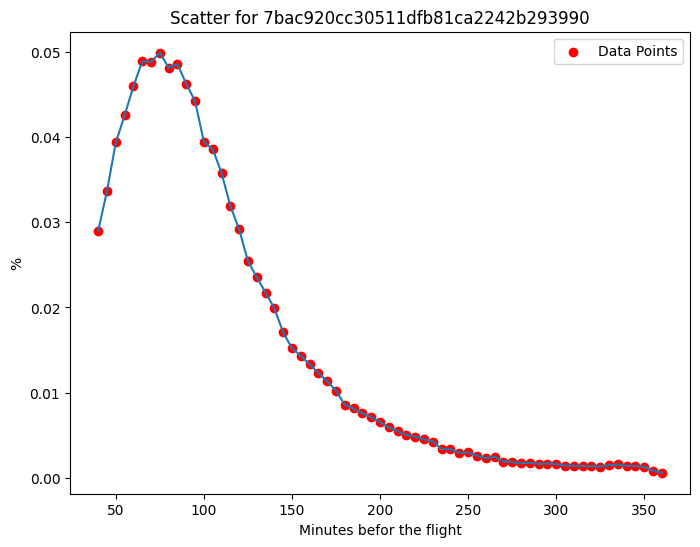

1.0000000000000002 -0.0


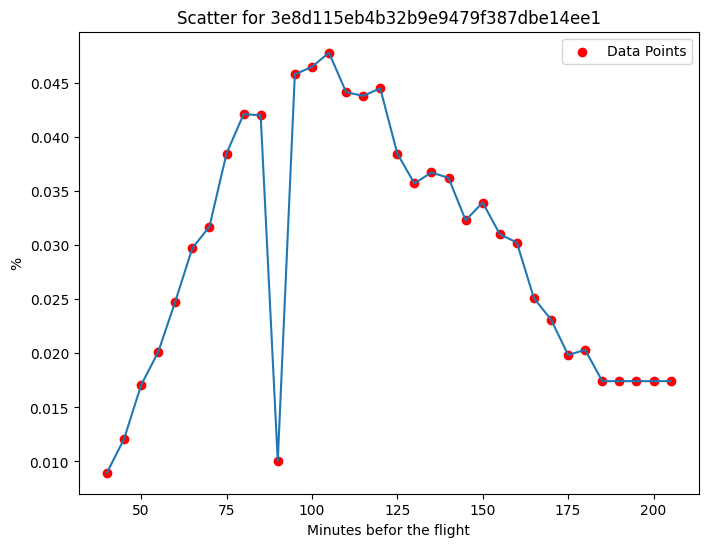

1.0 0.0


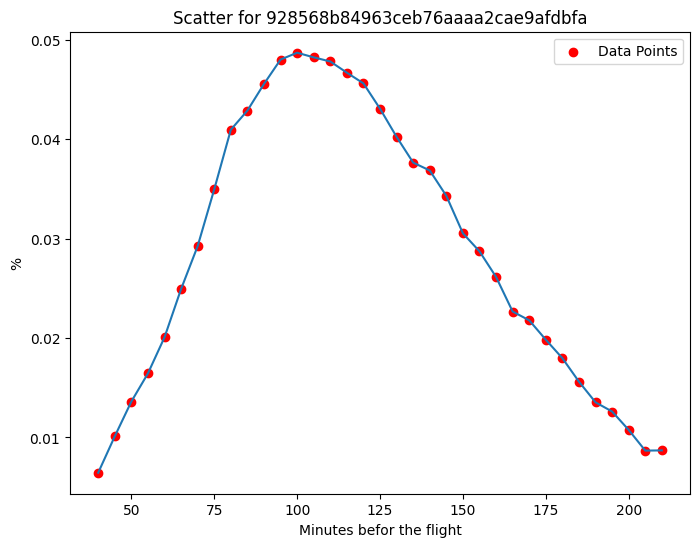

1.0 0.0


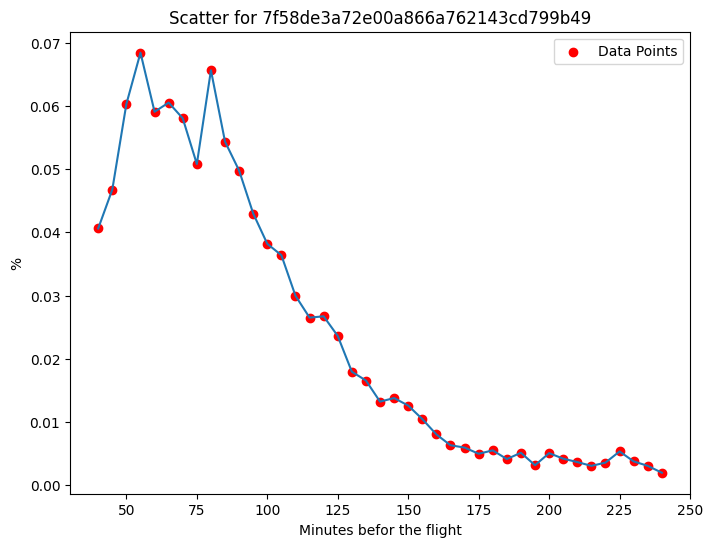

1.0 0.0


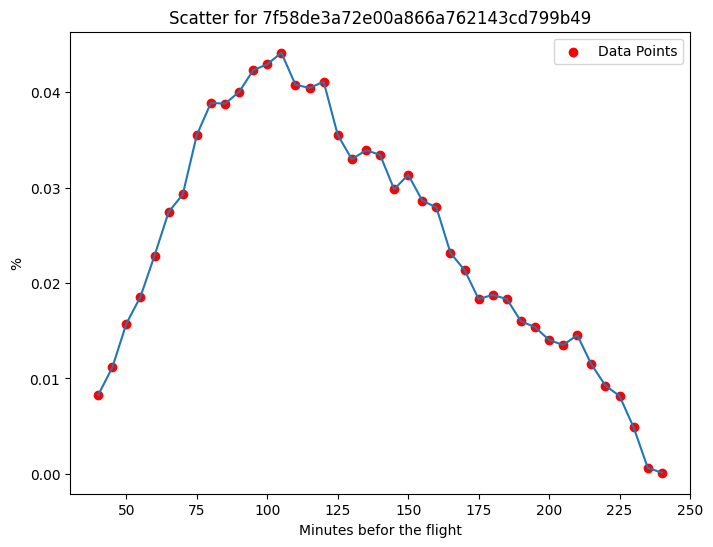

1.0 0.0


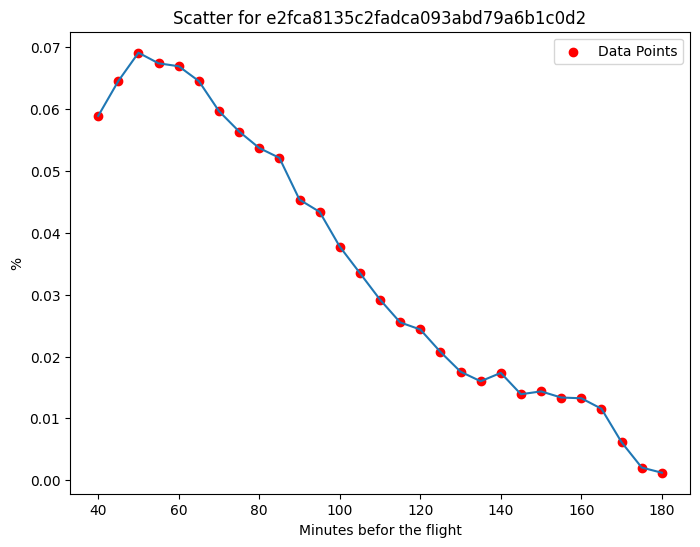

1.0 0.0


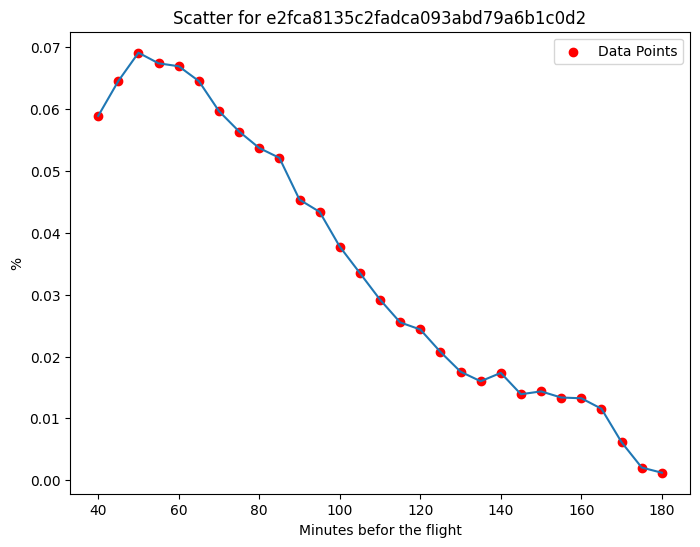

1.0 0.0


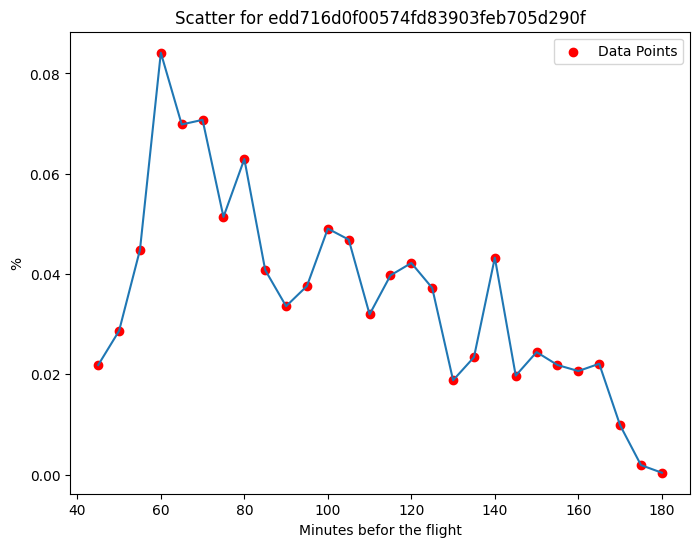

1.0 0.0


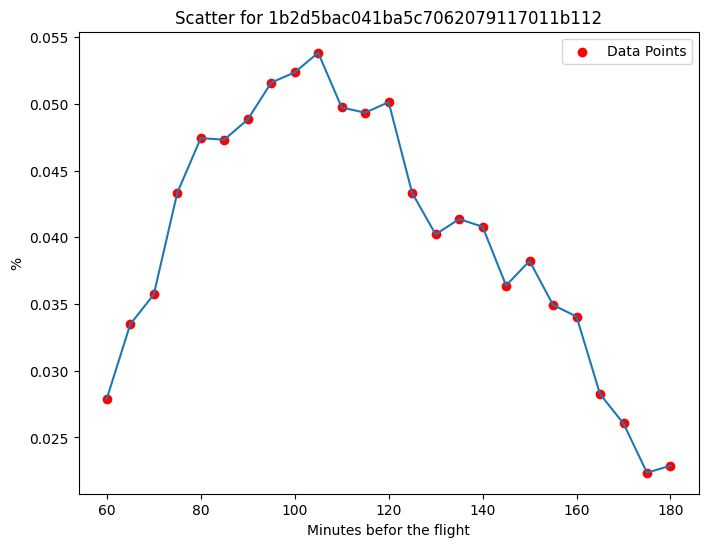

1.0 0.0


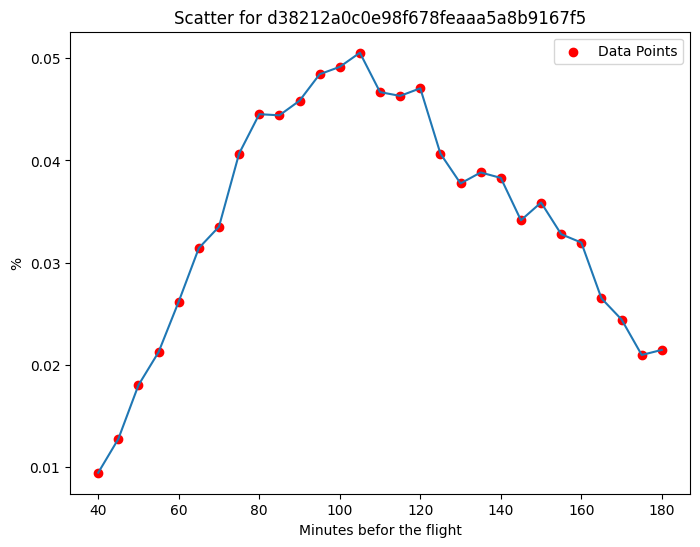

1.0 0.0


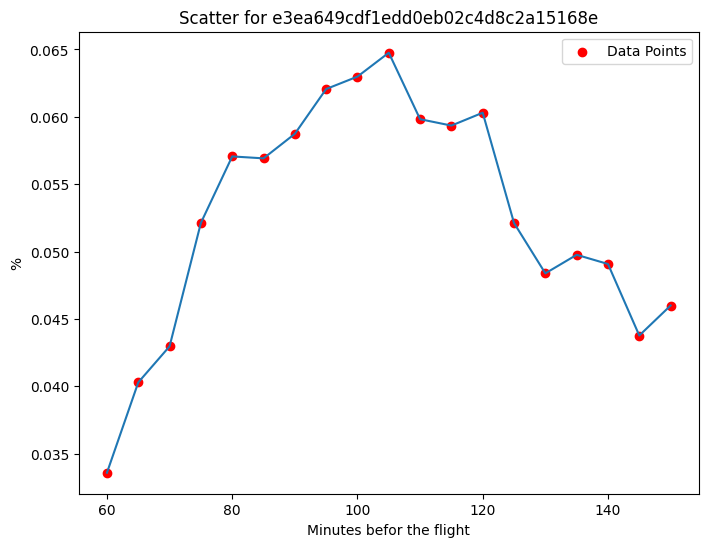

1.0 0.0


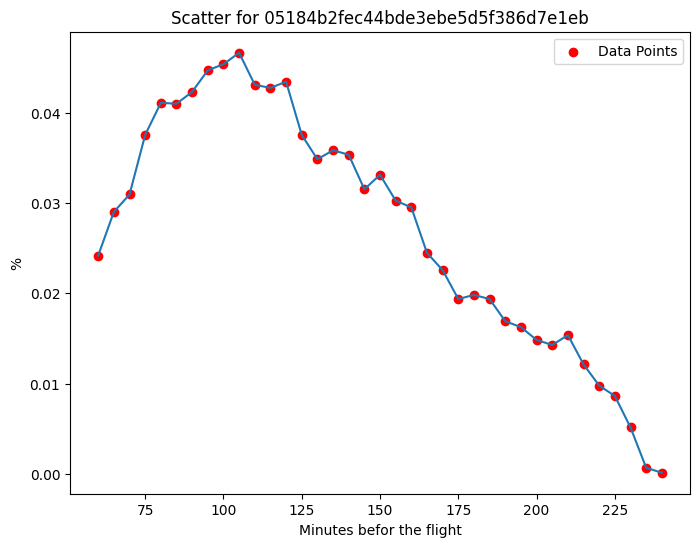

1.0 0.0


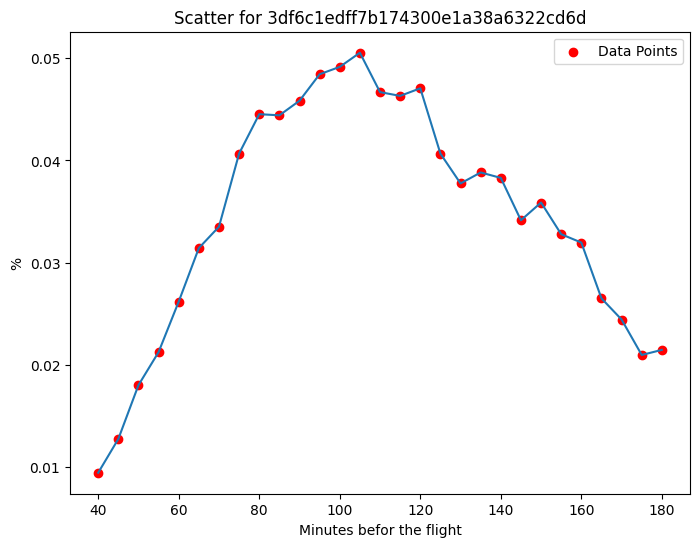

1.0 0.0


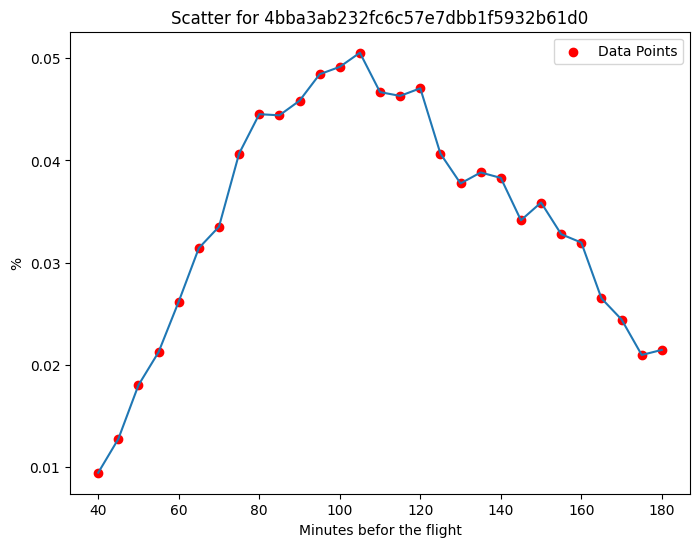

0.9999999999999999 0.0


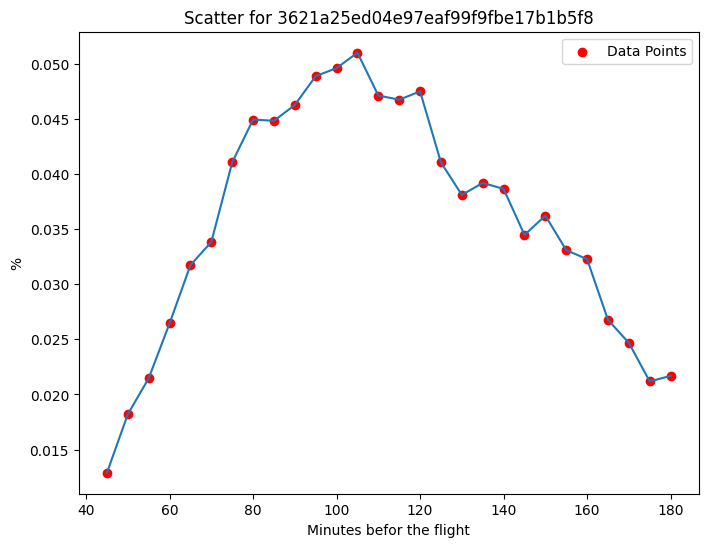

1.0 0.0


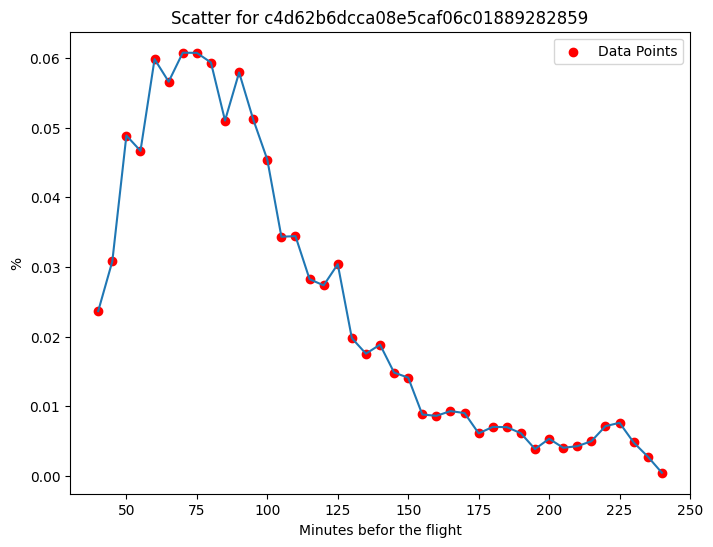

0.9999999999999998 0.0


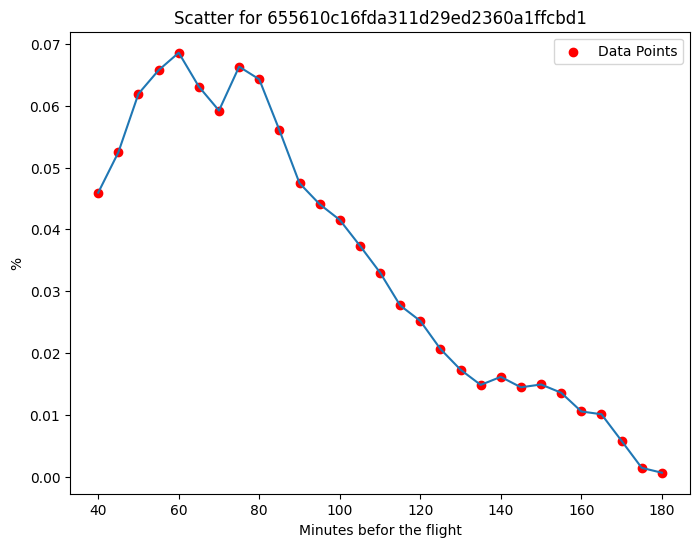

1.0 0.0


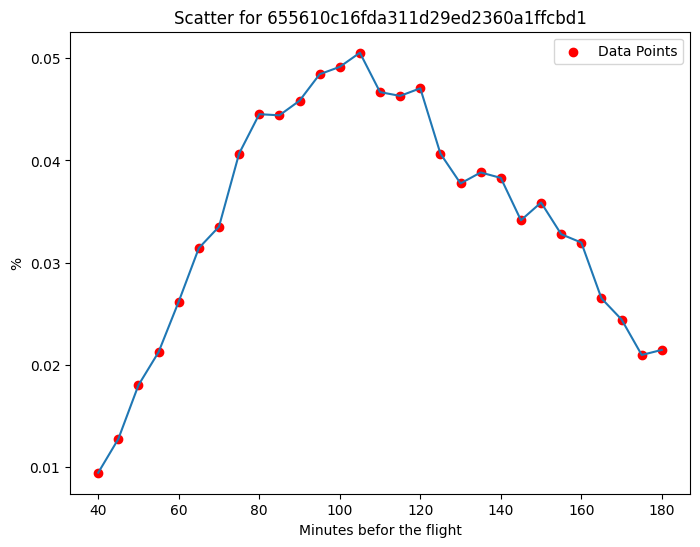

0.9999999999999999 0.0


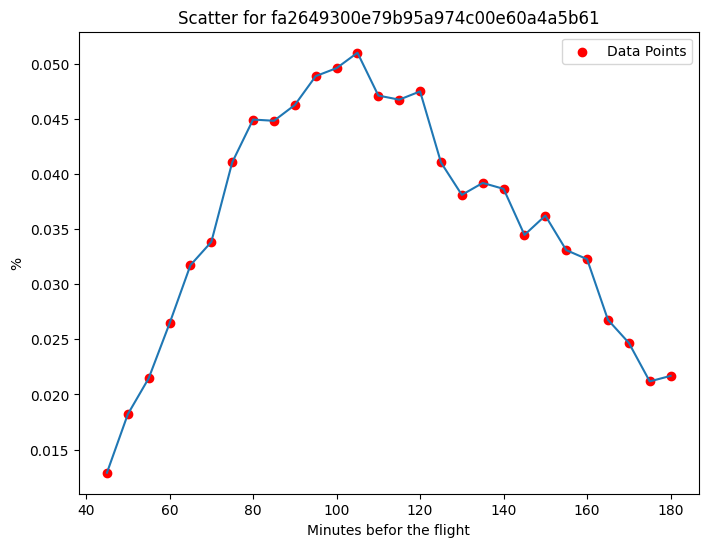

1.0 0.0


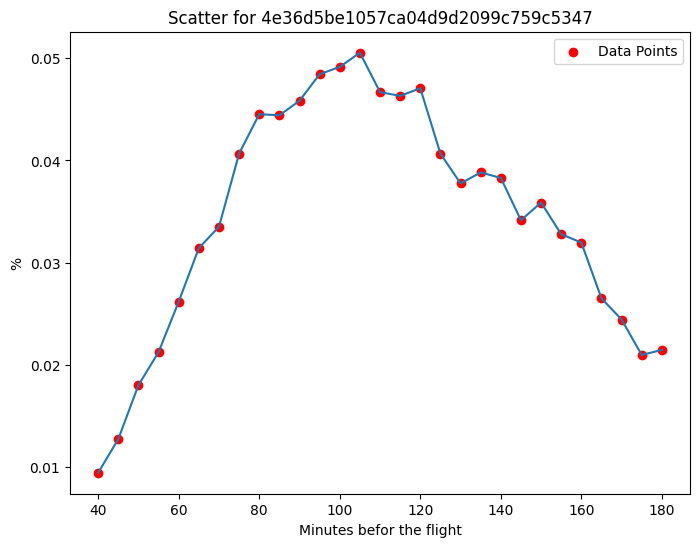

1.0 0.0


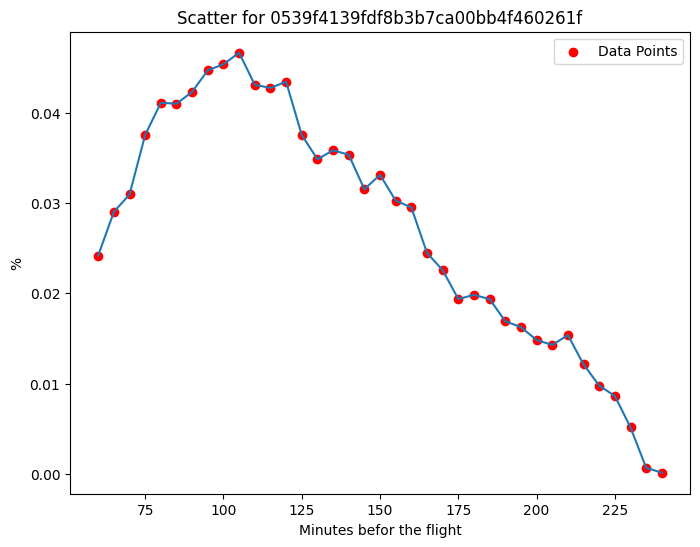

1.0 0.0


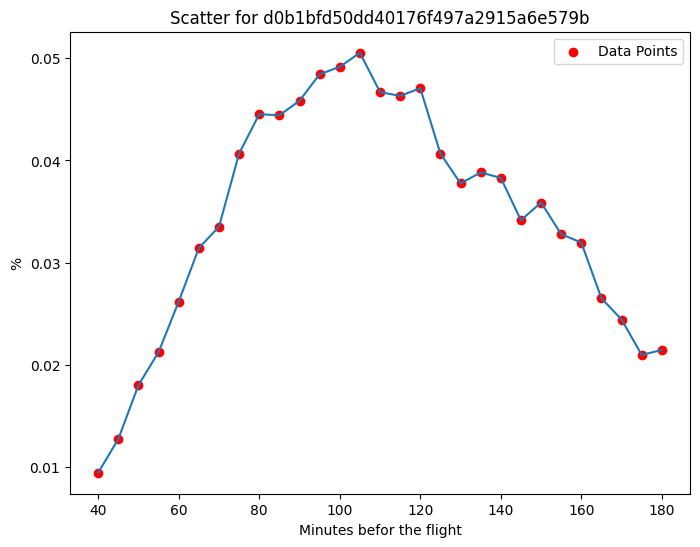

1.0 0.0


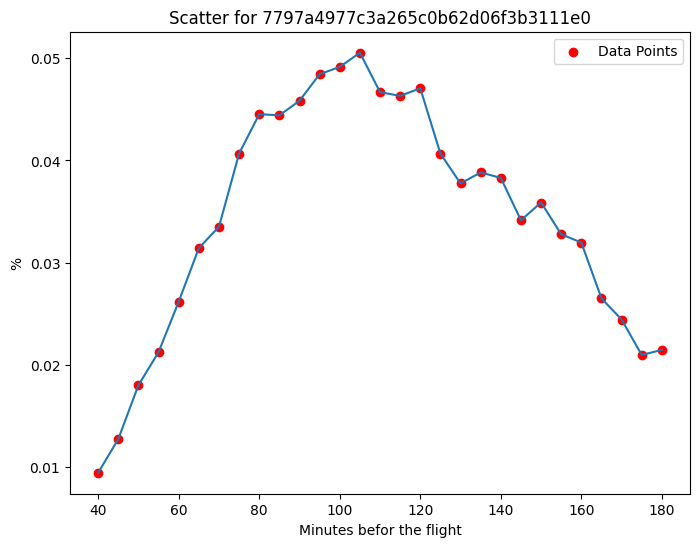

1.0 0.0


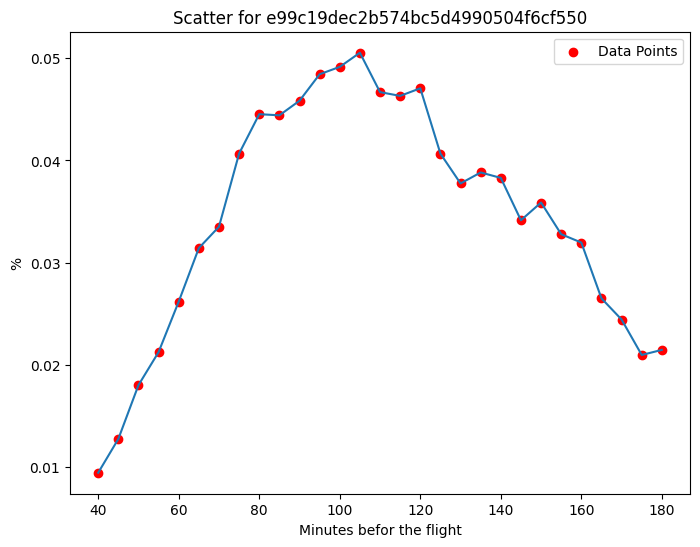

1.0 0.0


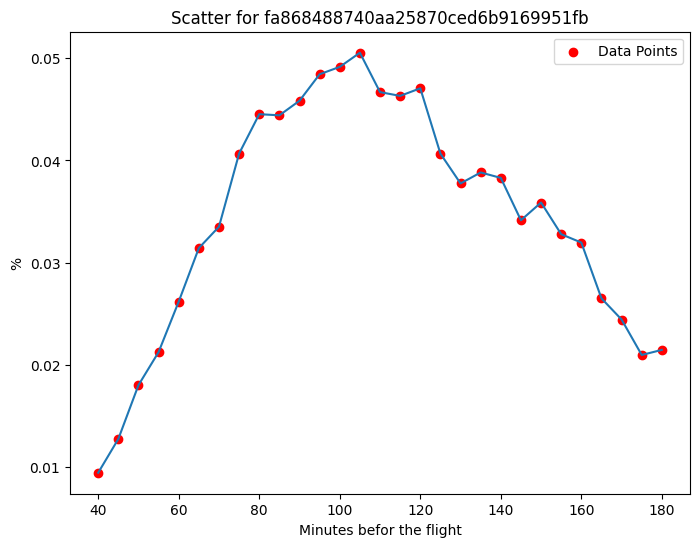

1.0 0.0


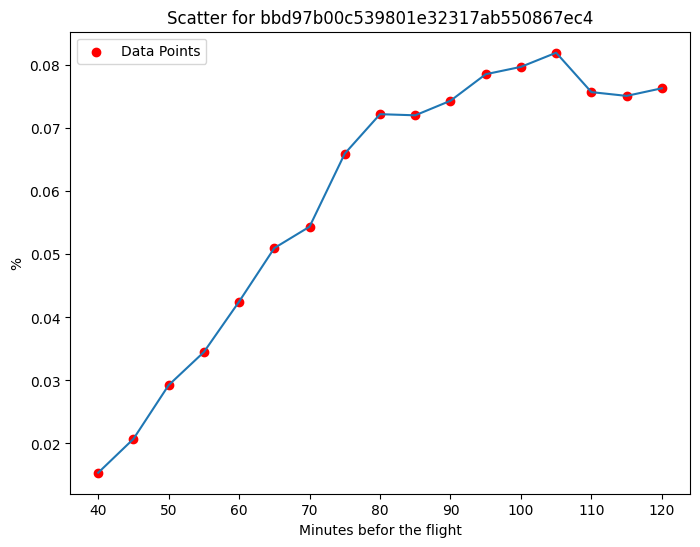

1.0 0.0


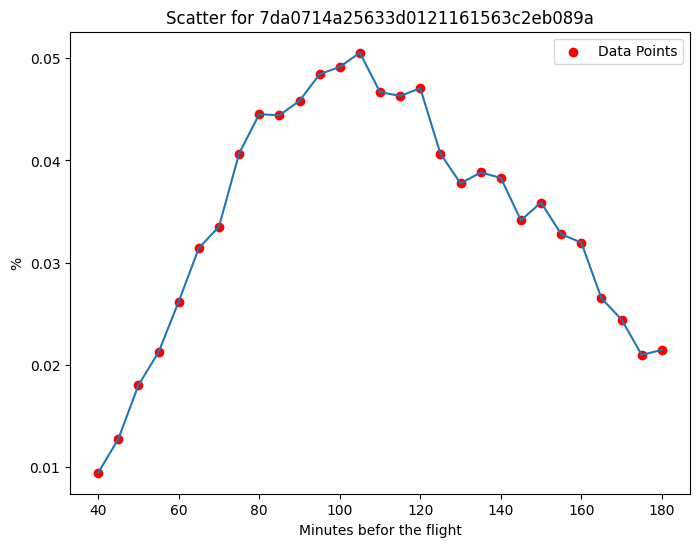

1.0 0.0


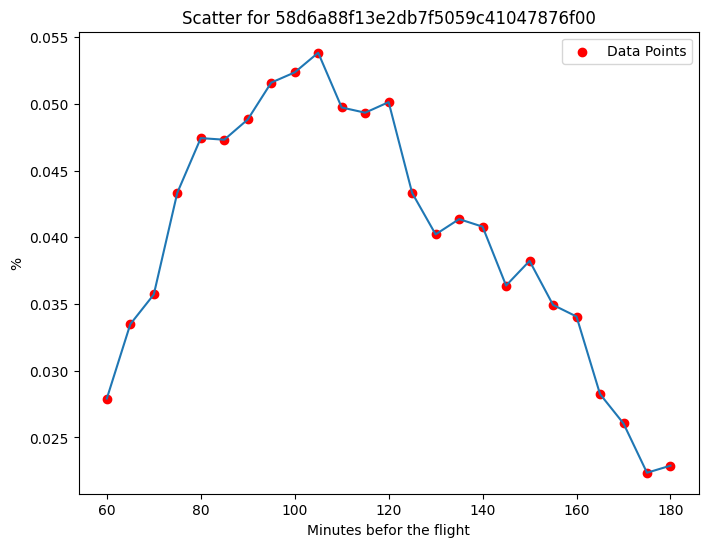

1.0 0.0


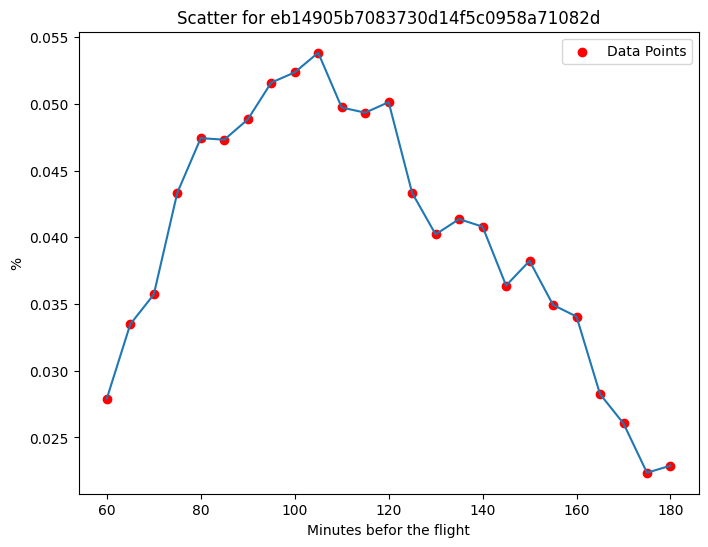

1.0 0.0


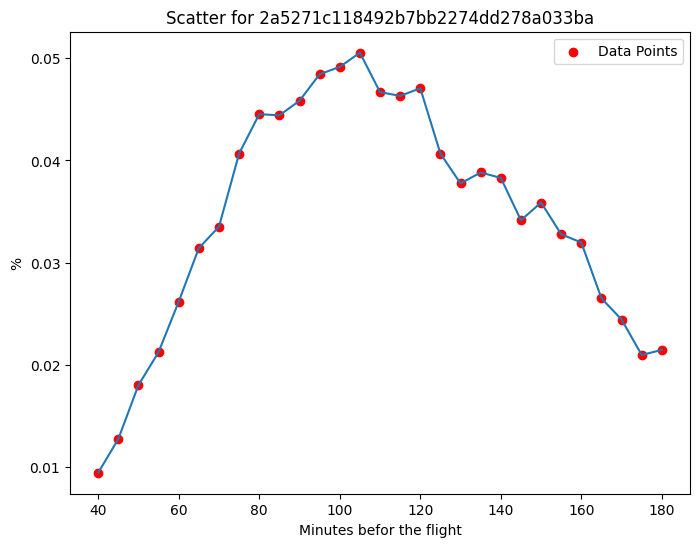

1.0 0.0


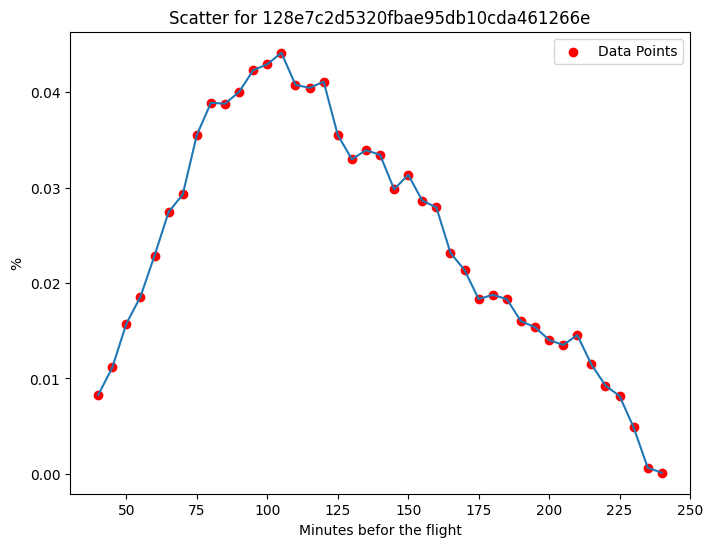

0.9999999999999999 0.0


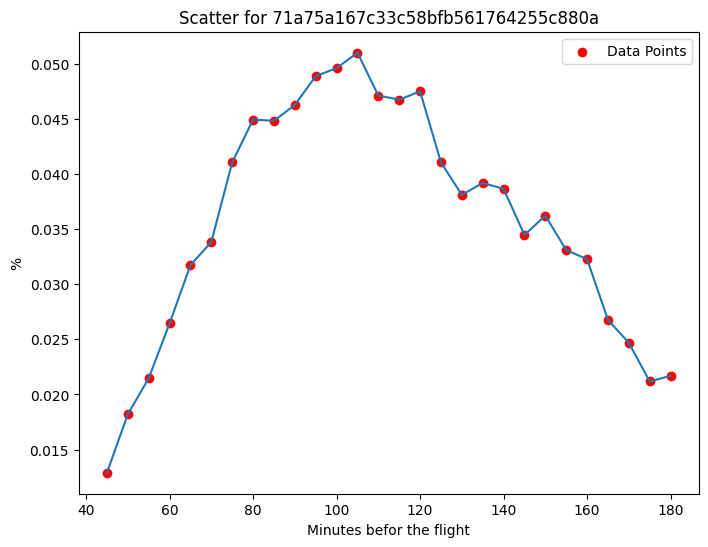

1.0 0.0


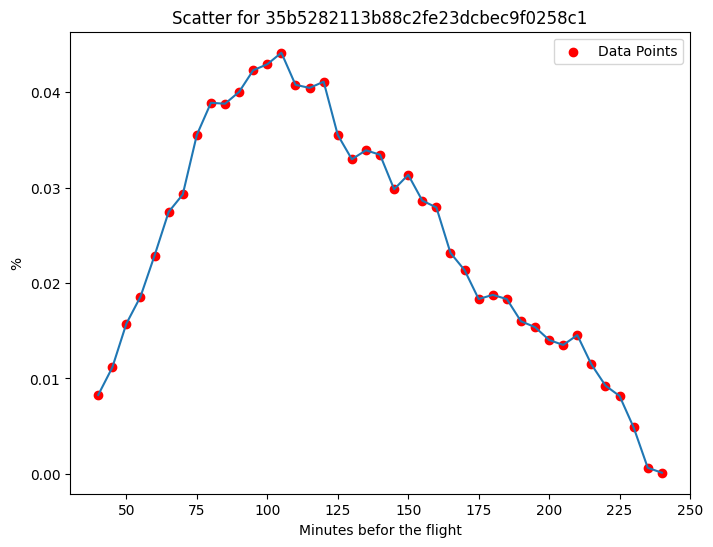

1.0 0.0


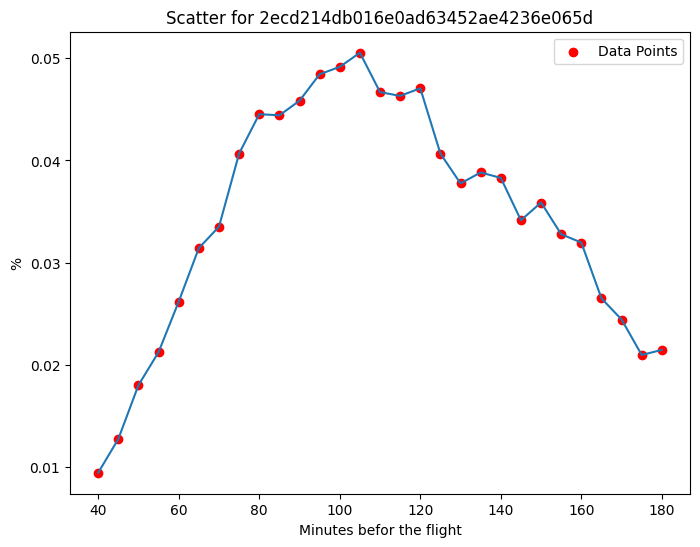

1.0 0.0


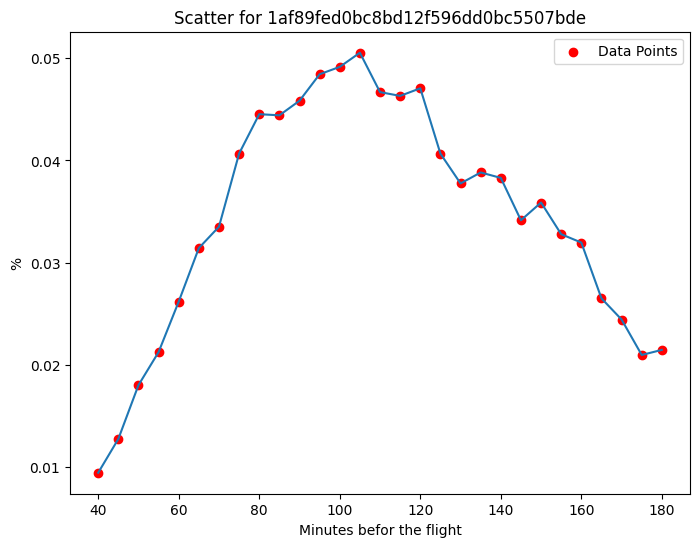

1.0 0.0


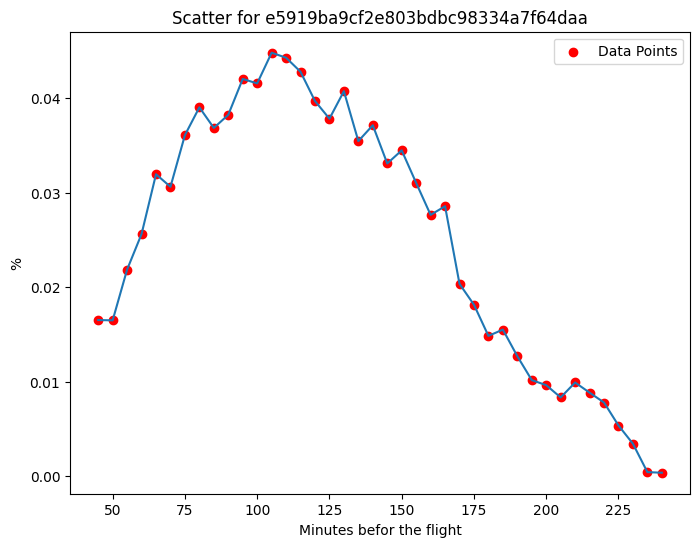

1.0 0.0


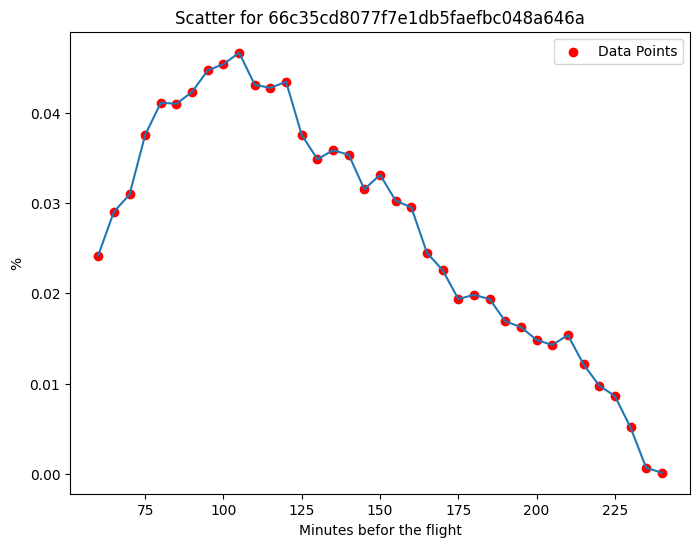

1.0 0.0


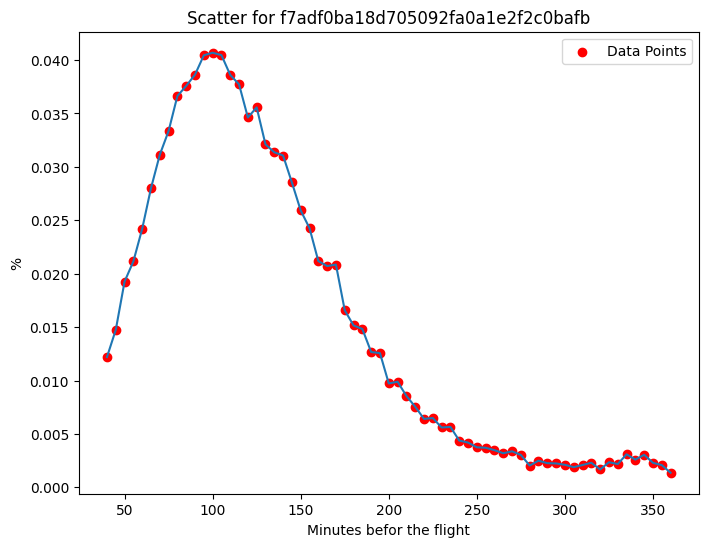

0.9999999999999999 0.0


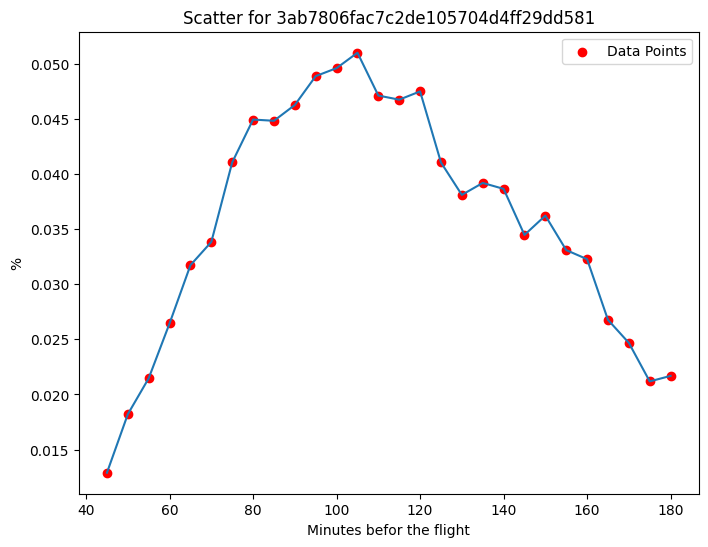

1.0 0.0


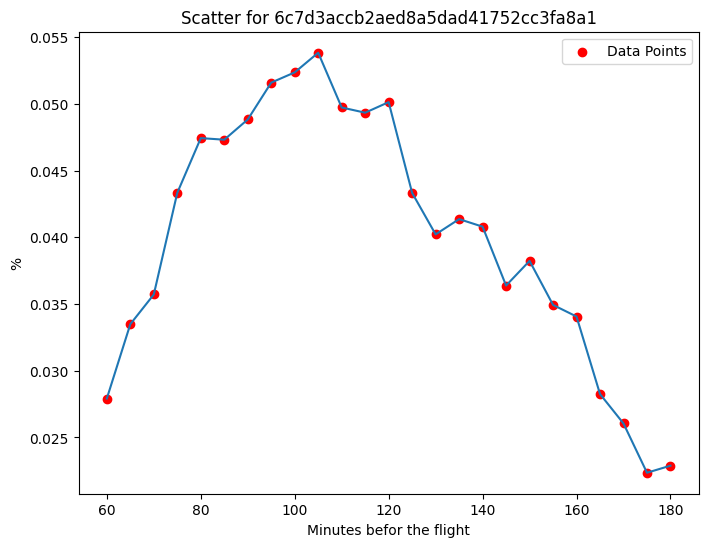

1.0 0.0


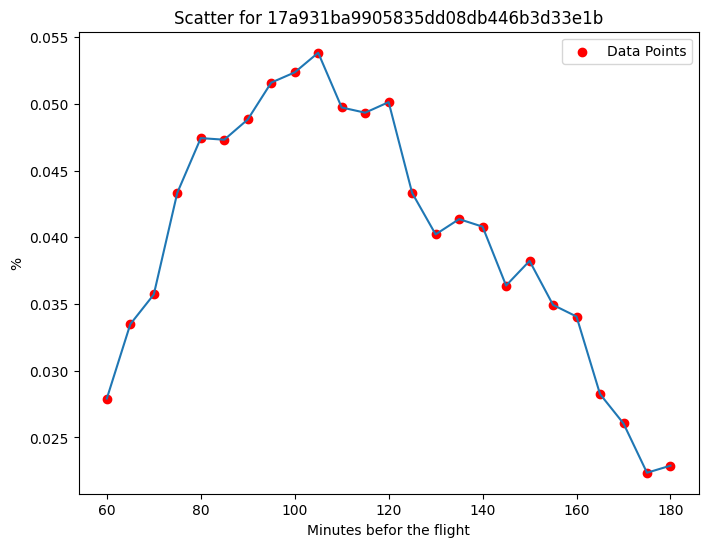

In [7]:
diff_airlines_test = profile_value_dict['airline_grouped_hash'].unique()
diff_terminals_test = profile_value_dict['checkin_terminal'].unique()
for airline_group in diff_airlines_test:
    for terminal in diff_terminals_test:
        distribution_test = profile_value_dict.loc[(profile_value_dict['airline_grouped_hash'] == airline_group)
                                                   & (profile_value_dict['checkin_terminal'] == terminal)]
        if distribution_test.size != 0:
                distribution_test = distribution_test.sort_values(by=['arrival_profile'],ignore_index=True)
                distribution_test.at[10, 'value'] += round(1 - distribution_test['value'].sum(),6)
                print(distribution_test['value'].sum(), round(1 - distribution_test['value'].sum(),6))
                plt.figure(figsize=(8, 6))
                plt.plot(distribution_test['arrival_profile'], distribution_test['value'])
                plt.scatter(distribution_test['arrival_profile'], distribution_test['value'], label='Data Points', c='red')
                plt.xlabel('Minutes befor the flight')
                plt.ylabel('%')
                plt.title('Scatter for ' + airline_group)
                plt.legend()
                plt.show()

## Bag number distribution dictionary (bag_dist_dict)

In [9]:
rasp = pd.read_csv('data/train/flight_rasp_data.csv')
rasp['t_st'] = pd.to_datetime(rasp['t_st'])

In [10]:
extended_combined_bsm = pd.merge(combined_bsm_data, rasp, on='i_id', how='left')
df_grouped = extended_combined_bsm.groupby(['pax_id_hash', 'airline_grouped_hash', 'm_city_rus2']).size().reset_index(name='count')
df_grouped['count'].value_counts()

count
1     1826669
2      219988
3       25286
4       13070
5        2186
6        1111
8         320
7          80
10         45
9          25
Name: count, dtype: int64

In [11]:
bag_dist_dict = df_grouped.groupby([ 'airline_grouped_hash', 'm_city_rus2', 'count']).size().reset_index(name='count_cases')
bag_dist_dict.rename(columns={'count': 'number_of_bags'}, inplace=True)
bag_dist_dict.head()

,airline_grouped_hash,m_city_rus2,number_of_bags,count_cases
0,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,1,10043
1,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,2,1964
2,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,3,466
3,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,4,127
4,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,5,41


In [12]:
grouped_by_airline_drection = bag_dist_dict.groupby(['airline_grouped_hash', 'm_city_rus2'])
total_count_cases = grouped_by_airline_drection['count_cases'].transform('sum')
bag_dist_dict['percentage'] = bag_dist_dict['count_cases'] / total_count_cases
bag_dist_dict

,airline_grouped_hash,m_city_rus2,number_of_bags,count_cases,percentage
0,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,1,10043,0.793599
1,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,2,1964,0.155196
2,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,3,466,0.036823
3,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,4,127,0.010036
4,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,5,41,0.003240
...,...,...,...,...,...
1129,fa2649300e79b95a974c00e60a4a5b61,Ереван,3,167,0.018523
1130,fa2649300e79b95a974c00e60a4a5b61,Ереван,4,55,0.006100
1131,fa2649300e79b95a974c00e60a4a5b61,Ереван,5,19,0.002107
1132,fa2649300e79b95a974c00e60a4a5b61,Ереван,6,1,0.000111


## Probability of no bag (no_bag_prob_dict)

In [14]:
#unique passengers
extended_bsm = pd.merge(combined_bsm_data, rasp, on='i_id', how='left')
df_grouped_no_bag_passenger = extended_combined_bsm.groupby(['pax_id_hash', 'airline_grouped_hash', 'm_city_rus2', 'i_id', 'config']).size().reset_index(name='count')
df_grouped_no_bag_passenger

,pax_id_hash,airline_grouped_hash,m_city_rus2,i_id,config,count
0,00000b86b52c66389b71ea7fd01c5a41,7f58de3a72e00a866a762143cd799b49,Казань,8668915.0,189.0,1
1,00000c4ad40ecb35e65770403e0a5bc7,66c35cd8077f7e1db5faefbc048a646a,Доха,8642564.0,254.0,1
2,00000ce3d76ae441e4eeb400837221d8,7bac920cc30511dfb81ca2242b293990,Пермь,8640737.0,140.0,1
3,00000d48d489ef6ad95999ffb487a316,eb14905b7083730d14f5c0958a71082d,Абу-Даби,8659789.0,290.0,1
4,00000db9ef34e53b7da3f4f4a4b35ebf,7bac920cc30511dfb81ca2242b293990,Новокузнецк,8645122.0,158.0,1
...,...,...,...,...,...,...
2088775,ffffc72e72f8e817c3e41512297c4eca,f7adf0ba18d705092fa0a1e2f2c0bafb,Ереван,8637489.0,158.0,1
2088776,ffffd758ff63a509a7f0b2b9d8bb5fea,7bac920cc30511dfb81ca2242b293990,Санкт-Петербург,8641676.0,158.0,1
2088777,ffffdf1368517875d4a4e4135dee6916,7bac920cc30511dfb81ca2242b293990,Сочи,8693329.0,158.0,2
2088778,ffffe13ae3f6942c0a188b84b7871171,7bac920cc30511dfb81ca2242b293990,Сочи,8644756.0,196.0,1


In [15]:
#percentage of no baggs or no passengers
df_grouped_no_bag_flight = df_grouped_no_bag_passenger.groupby(['airline_grouped_hash', 'm_city_rus2', 'i_id', 'config']).size().reset_index(name='count')
df_grouped_no_bag_flight['percentageOfNonZero'] = df_grouped_no_bag_flight['count'] / df_grouped_no_bag_flight['config']
df_grouped_no_bag_flight['percentageOfZero'] = 1 - df_grouped_no_bag_flight['percentageOfNonZero']
df_grouped_no_bag_flight

,airline_grouped_hash,m_city_rus2,i_id,config,count,percentageOfNonZero,percentageOfZero
0,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,8630464.0,230.0,85,0.369565,0.630435
1,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,8631346.0,230.0,168,0.730435,0.269565
2,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,8633061.0,230.0,189,0.821739,0.178261
3,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,8633926.0,230.0,223,0.969565,0.030435
4,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,8634818.0,230.0,218,0.947826,0.052174
...,...,...,...,...,...,...,...
27644,fa2649300e79b95a974c00e60a4a5b61,Ереван,8693267.0,131.0,94,0.717557,0.282443
27645,fa2649300e79b95a974c00e60a4a5b61,Ереван,8694248.0,131.0,101,0.770992,0.229008
27646,fa2649300e79b95a974c00e60a4a5b61,Ереван,8695181.0,131.0,111,0.847328,0.152672
27647,fa2649300e79b95a974c00e60a4a5b61,Ереван,8696136.0,131.0,105,0.801527,0.198473


In [16]:
no_bag_prob_dict = df_grouped_no_bag_flight.groupby(['airline_grouped_hash', 'm_city_rus2'])['percentageOfZero'].mean().reset_index(name='avg_zero_prob')
no_bag_prob_dict['avg_zero_prob'] = no_bag_prob_dict['avg_zero_prob'].apply(lambda x: 0 if x < 0 else x)
no_bag_prob_dict

,airline_grouped_hash,m_city_rus2,avg_zero_prob
0,05184b2fec44bde3ebe5d5f386d7e1eb,Маскат,0.000000
1,100d796971d49bd1046f553b9b942ae7,Анталья,0.305825
2,128e7c2d5320fbae95db10cda461266e,Варадеро,0.458723
3,128e7c2d5320fbae95db10cda461266e,Костанай,0.723396
4,128e7c2d5320fbae95db10cda461266e,Хургада,0.352381
...,...,...,...
183,f7adf0ba18d705092fa0a1e2f2c0bafb,Фергана,0.486946
184,f7adf0ba18d705092fa0a1e2f2c0bafb,Хургада,0.424318
185,f7adf0ba18d705092fa0a1e2f2c0bafb,Шанхай,0.510009
186,f7adf0ba18d705092fa0a1e2f2c0bafb,Шарм-эль-Шейх,0.385045


# Main simulation

In [17]:
dict_results = {}


def estimate_time(checkin_terminal, airline_grouped_hash):
    global profile_value_dict
    distribution = profile_value_dict.loc[(profile_value_dict['checkin_terminal'] == checkin_terminal) &
                                          (profile_value_dict['airline_grouped_hash'] == airline_grouped_hash)]
    if distribution.size == 0:
            distribution = profile_value_dict.loc[(profile_value_dict['checkin_terminal'] == 'C') &
                                          (profile_value_dict['airline_grouped_hash'] == '928568b84963ceb76aaaa2cae9afdbfa')]
    distribution = distribution.sort_values(by=['arrival_profile'],ignore_index=True)
    distribution.at[10, 'value'] += round(1 - distribution['value'].sum(),6)
    time = np.random.choice(distribution['arrival_profile'], p=distribution['value'])
    return time


def estimate_bags(airline_grouped_hash, m_city_rus2):
    global bag_dist_dict, no_bag_prob_dict
    #print('orig_dist')
    distribution = bag_dist_dict.loc[(bag_dist_dict['airline_grouped_hash'] == airline_grouped_hash) &
                                     (bag_dist_dict['m_city_rus2'] == m_city_rus2)]
    if distribution.size != 0:
        distribution = distribution.sort_values(by=['number_of_bags'],ignore_index=True)
        distribution.at[0, 'percentage'] += round(1 - distribution['percentage'].sum(),6)
        number_of_bags = np.random.choice(distribution['number_of_bags'], p=distribution['percentage'])
    else:
        number_of_bags = 0
    #print('no_bag_dist')
    distribution_no_bags = no_bag_prob_dict.loc[(no_bag_prob_dict['airline_grouped_hash'] == airline_grouped_hash) &
                                    (no_bag_prob_dict['m_city_rus2'] == m_city_rus2)]
    if distribution_no_bags.size != 0:
        is_attending = np.random.choice([0,1], p=[distribution_no_bags.iloc[0]['avg_zero_prob'], 
                                                1 - distribution_no_bags.iloc[0]['avg_zero_prob']])
    else:
        is_attending = 1
    return number_of_bags * is_attending


def row_application(row):
    #print(row)
    global dict_results
    for i in range(int(row['config'])):
        #print('time_calc')
        time_shift = estimate_time(row['checkin_terminal'], row['airline_grouped_hash'])
        #print('bag_calc')
        number_of_bags = estimate_bags(row['airline_grouped_hash'], row['m_city_rus2'])
        #print('transform_time')
        time = str(row['t_st'] - pd.Timedelta(minutes=time_shift))
        #print('add_time')
        if time in dict_results:
            dict_results[time] += number_of_bags


def simulation(rasp_test, start_ts, end_ts, ground_truth):
    global dict_results
    estimation_rasp = rasp_test.loc[(rasp_test['t_st'] >= pd.Timestamp(start_ts)) 
                            & (rasp_test['t_st'] <= pd.Timestamp(end_ts) + pd.Timedelta(hours=2))]
    
    prediction = ground_truth.loc[(ground_truth['timestamp'] >= pd.Timestamp(start_ts)) 
                            & (ground_truth['timestamp'] <= pd.Timestamp(end_ts))]
    dict_results = {str(key): 0 for key in prediction['timestamp']}
    estimation_rasp.apply(row_application, axis=1)


rasp_T = pd.read_csv('data/train/flight_rasp_data.csv')
rasp_T['t_st'] = pd.to_datetime(rasp_T['t_st'])
rasp_T = rasp_T.drop(['i_id','departure_terminal', 'cco_hash', 'flt_hash', 'm_city_rus1'], axis=1)

simulation(rasp_T, '2023-09-01T00', '2023-09-12T00', ground_truth)

In [18]:
simulation_res = pd.DataFrame.from_dict(dict_results, orient='index', columns=['count'])
simulation_res['count'] = simulation_res['count'].apply(lambda x: round(x * 0.8))
simulation_res['timestamp'] = pd.to_datetime(simulation_res.index)
simulation_res = simulation_res.sort_values(by=['timestamp'],ignore_index=True)

ground_truth_interval = ground_truth.loc[(ground_truth['timestamp'] >= pd.Timestamp('2023-09-01T00')) 
                            & (ground_truth['timestamp'] <= pd.Timestamp('2023-09-12T00'))]
ground_truth_interval = ground_truth_interval.sort_values(by=['timestamp'],ignore_index=True)

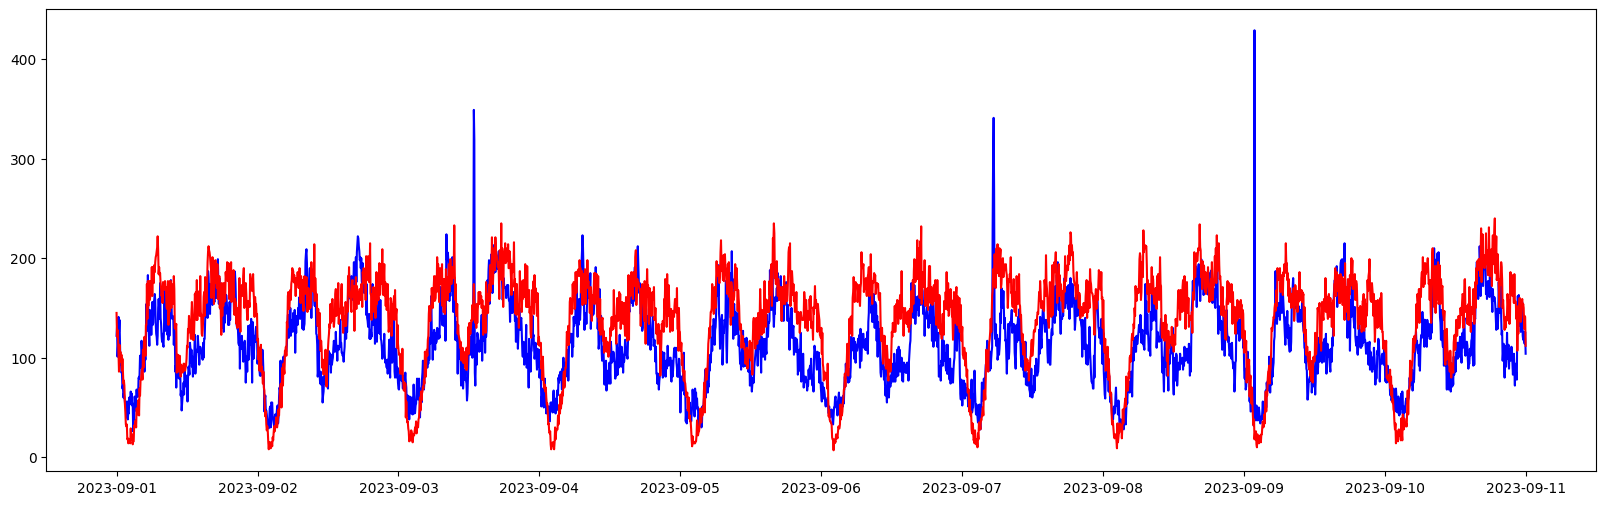

In [19]:
plt.figure(figsize=(20, 6))
plt.plot(ground_truth_interval['timestamp'], ground_truth_interval['count'], color='blue')
plt.plot(simulation_res['timestamp'], simulation_res['count'], color='red')
plt.show()

In [20]:
mean = simulation_res['count'].mean()
std_dev = simulation_res['count'].std()
#z_score = stats.norm.ppf((1 + 0.999) / 2)
#margin_of_error = z_score * (std_dev / np.sqrt(len(simulation_res)))
simulation_res['lower_bound'] = simulation_res['count'] - 70
simulation_res['upper_bound'] = simulation_res['count'] + 70

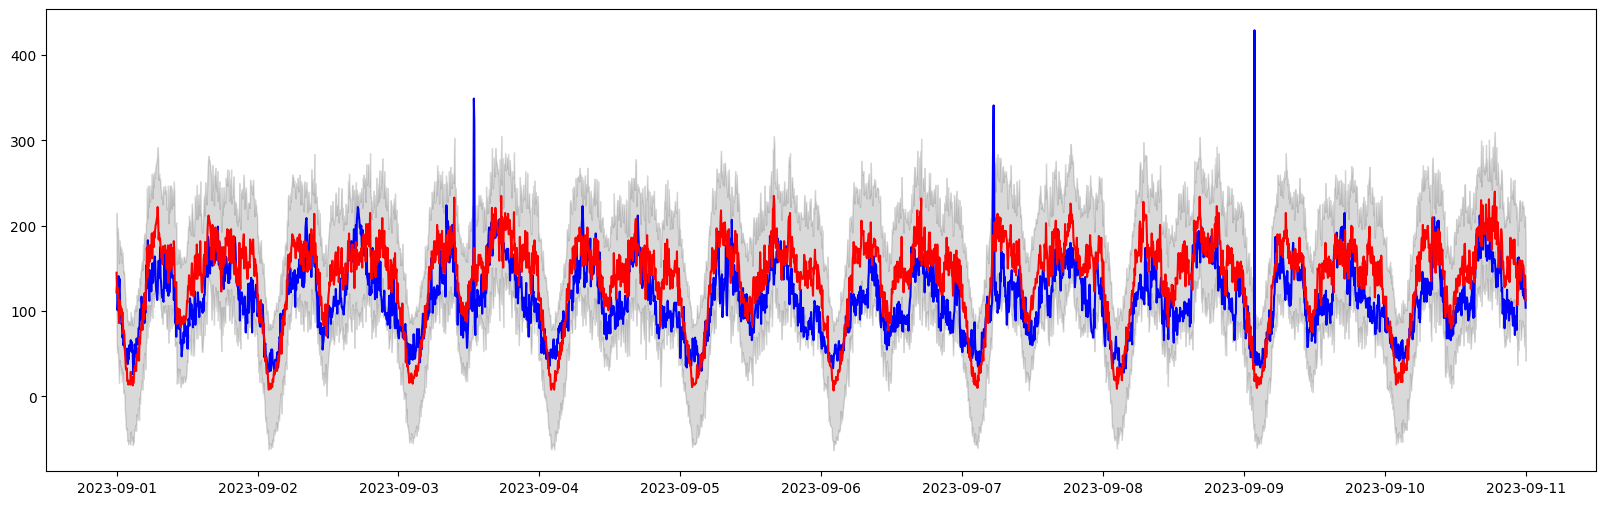

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(ground_truth_interval['timestamp'], ground_truth_interval['count'], color='blue')
plt.plot(simulation_res['timestamp'], simulation_res['count'], color='red')
plt.fill_between(simulation_res['timestamp'], simulation_res['upper_bound'], 
                 simulation_res['lower_bound'], color="k", alpha=0.15)
plt.show()

In [22]:
extended = pd.merge(ground_truth_interval, simulation_res, on='timestamp', how='left')
extended['outlier'] = extended.apply(lambda x: 1 if (x['count_x'] < x['lower_bound'] or
                                                      x['count_x'] > x['upper_bound']) else 0, axis=1)
extended 

,timestamp,count_x,count_y,lower_bound,upper_bound,outlier
0,2023-09-01 00:00:00,122,145,75,215,0
1,2023-09-01 00:05:00,131,121,51,191,0
2,2023-09-01 00:10:00,101,128,58,198,0
3,2023-09-01 00:15:00,112,121,51,191,0
4,2023-09-01 00:20:00,141,103,33,173,0
...,...,...,...,...,...,...
2875,2023-09-10 23:35:00,126,150,80,220,0
2876,2023-09-10 23:40:00,117,129,59,199,0
2877,2023-09-10 23:45:00,114,142,72,212,0
2878,2023-09-10 23:50:00,126,141,71,211,0


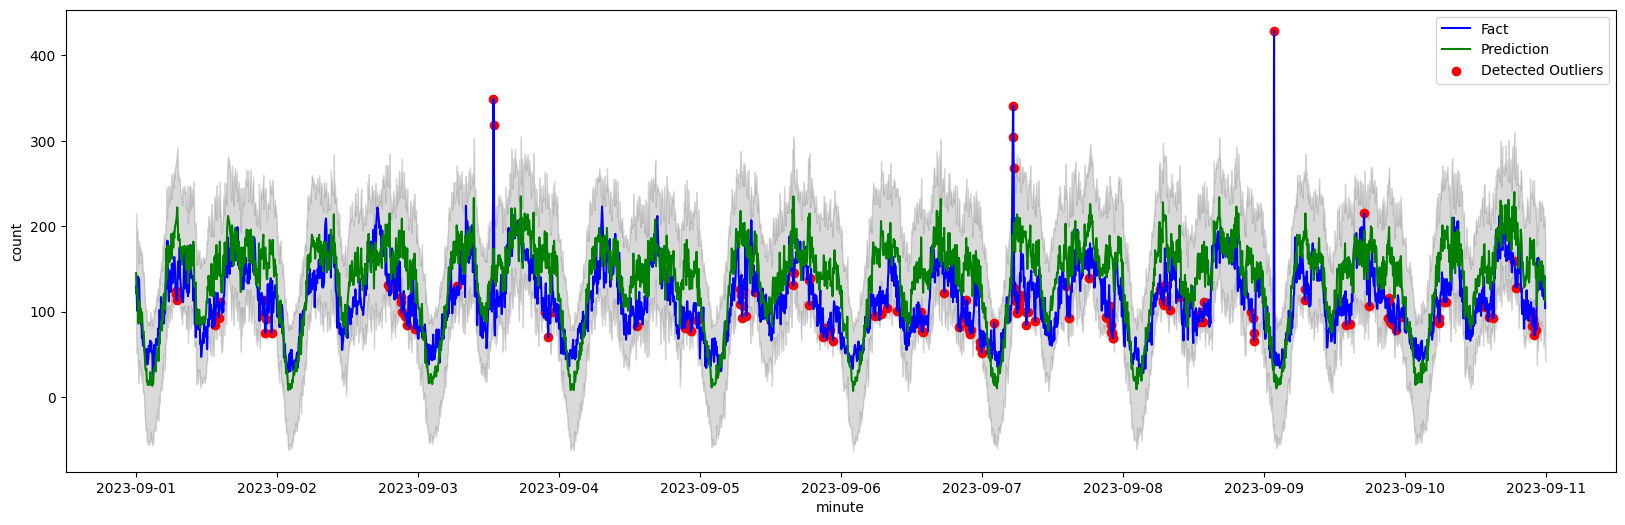

In [23]:
anomaly = extended.loc[extended['outlier'] == 1, ['timestamp', 'count_x']]

plt.figure(figsize=(20, 6))
plt.plot(extended['timestamp'], extended['count_x'], color='blue', label='Fact')
plt.plot(extended['timestamp'], extended['count_y'], color='green', label='Prediction')
plt.fill_between(extended['timestamp'], extended['upper_bound'], 
                 extended['lower_bound'], color="k", alpha=0.15)
plt.scatter(anomaly['timestamp'],anomaly['count_x'], color='red', label='Detected Outliers')
plt.xlabel('minute')
plt.ylabel('count')
plt.legend()
plt.show()

## Accuracy evaluation

In [29]:
combined_anomalies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20736 entries, 0 to 20735
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      20736 non-null  datetime64[ns]
 1   actualAnomaly  20736 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 324.1 KB


In [30]:
extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    2880 non-null   datetime64[ns]
 1   count_x      2880 non-null   int64         
 2   count_y      2880 non-null   int64         
 3   lower_bound  2880 non-null   int64         
 4   upper_bound  2880 non-null   int64         
 5   outlier      2880 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 135.1 KB


In [31]:
extended = pd.merge(extended, combined_anomalies, on='timestamp', how='left')

In [32]:
extended

,timestamp,count_x,count_y,lower_bound,upper_bound,outlier,actualAnomaly
0,2023-09-01 00:00:00,122,145,75,215,0,0
1,2023-09-01 00:05:00,131,121,51,191,0,0
2,2023-09-01 00:10:00,101,128,58,198,0,0
3,2023-09-01 00:15:00,112,121,51,191,0,0
4,2023-09-01 00:20:00,141,103,33,173,0,0
...,...,...,...,...,...,...,...
2875,2023-09-10 23:35:00,126,150,80,220,0,0
2876,2023-09-10 23:40:00,117,129,59,199,0,0
2877,2023-09-10 23:45:00,114,142,72,212,0,0
2878,2023-09-10 23:50:00,126,141,71,211,0,0


In [33]:
precision = precision_score(extended['actualAnomaly'], extended['outlier'])
recall = recall_score(extended['actualAnomaly'], extended['outlier'])
f_score = f1_score(extended['actualAnomaly'], extended['outlier'])
fpr, tpr, thresholds = roc_curve(extended['actualAnomaly'], extended['outlier'])
roc_auc = auc(fpr, tpr)
print('models performance:')
print("Precision: ", precision)
print("Recall: ", recall)
print("F-score: ", f_score)
print("ROC AUC: ", roc_auc)

models performance:
Precision:  0.03680981595092025
Recall:  0.75
F-score:  0.07017543859649122
ROC AUC:  0.8476671309192202
